In [2]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


# Training Setup

In [14]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=1000
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 1)
train_size=0.00108
train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2DFFT(reduction="sum", std=1e-4, store_filters="unorm")
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse  

No GPU available! Running on CPU


In [15]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            if epoch < switch_at_epoch:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, l2loss, device=device)
            else:
                epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi2D, device=device)
            epoch_mse = validate(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)
                if isinstance(recon, tuple): recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi2D(recon, X)
                v, T = awi2D.filters[0], awi2D.T

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                model = model.cpu()
                plot_grad_flow(model.named_parameters())
                model = model.to(device)

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0].permute(1,2,0).cpu().detach().numpy(), vmin=0., vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0].permute(1,2,0).cpu().detach().numpy() - recon[0].permute(1,2,0).cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].imshow(T.detach().cpu().numpy())
                axs[1, 0].set_title("T-2D")

                axs[1, 1].imshow(v.permute(1,2,0).detach().cpu().numpy())
                axs[1, 1].set_title("v-2D")

                axs[1, 2].plot((T.unsqueeze(0).repeat(v.shape[0], 1, 1).flatten() - v.flatten()).detach().cpu().numpy())
                axs[1, 2].set_ylim(None, 1.1)
                axs[1, 2].set_title("T2D - v2D")

                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss2d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# CIFAR10 Example

## Datasets and Dataloaders

In [16]:
# Train Transforms
train_transform = Compose([
    Resize(28),
])

# Datasets and dataloaders
ds = CIFAR10("./", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx =[7]
X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 1
torch.Size([1, 3, 28, 28]) 0.0673472136259079 0.9533613324165344


## Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.049722544848918915, 'train_awi1d_loss': 1.1293063163757324, 'train_kl_loss': 0.0}
 argidx T, v:  1512 4537


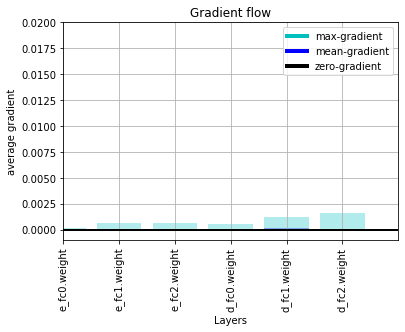

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


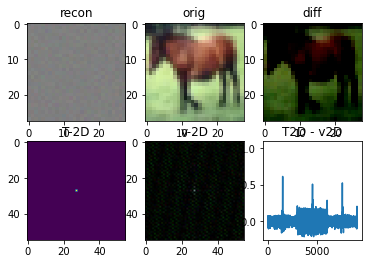

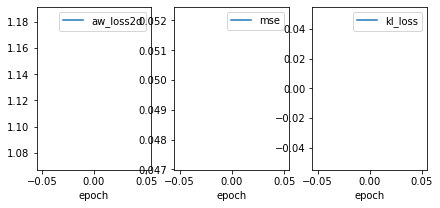

  0% (1 of 1000) |                       | Elapsed Time: 0:00:01 ETA:   0:17:14
  0% (2 of 1000) |                       | Elapsed Time: 0:00:01 ETA:   0:11:42
  0% (3 of 1000) |                       | Elapsed Time: 0:00:01 ETA:   0:09:49
  0% (4 of 1000) |                       | Elapsed Time: 0:00:02 ETA:   0:08:48
  0% (5 of 1000) |                       | Elapsed Time: 0:00:02 ETA:   0:08:17
  0% (6 of 1000) |                       | Elapsed Time: 0:00:02 ETA:   0:07:52
  0% (7 of 1000) |                       | Elapsed Time: 0:00:03 ETA:   0:06:02
  0% (8 of 1000) |                       | Elapsed Time: 0:00:03 ETA:   0:05:57
  0% (9 of 1000) |                       | Elapsed Time: 0:00:03 ETA:   0:05:58
  1% (10 of 1000) |                      | Elapsed Time: 0:00:04 ETA:   0:05:58
  1% (11 of 1000) |                      | Elapsed Time: 0:00:04 ETA:   0:06:01
  1% (12 of 1000) |                      | Elapsed Time: 0:00:05 ETA:   0:06:09
  1% (13 of 1000) |                     


 {'epoch': 100, 'train_mse': 0.04492776095867157, 'train_awi1d_loss': 0.49748775362968445, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


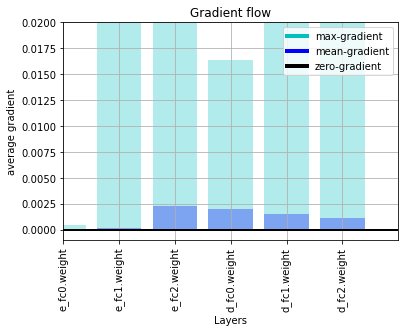

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


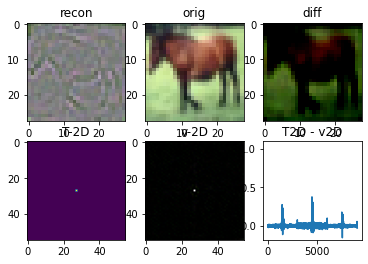

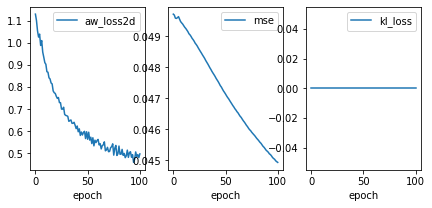

 10% (101 of 1000) |##                   | Elapsed Time: 0:00:38 ETA:   0:07:52
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:38 ETA:   0:07:55
 10% (103 of 1000) |##                   | Elapsed Time: 0:00:38 ETA:   0:07:47
 10% (104 of 1000) |##                   | Elapsed Time: 0:00:39 ETA:   0:07:48
 10% (105 of 1000) |##                   | Elapsed Time: 0:00:39 ETA:   0:07:21
 10% (106 of 1000) |##                   | Elapsed Time: 0:00:40 ETA:   0:07:02
 10% (107 of 1000) |##                   | Elapsed Time: 0:00:40 ETA:   0:05:24
 10% (108 of 1000) |##                   | Elapsed Time: 0:00:40 ETA:   0:05:21
 10% (109 of 1000) |##                   | Elapsed Time: 0:00:41 ETA:   0:05:25
 11% (110 of 1000) |##                   | Elapsed Time: 0:00:41 ETA:   0:05:22
 11% (111 of 1000) |##                   | Elapsed Time: 0:00:41 ETA:   0:05:17
 11% (112 of 1000) |##                   | Elapsed Time: 0:00:42 ETA:   0:05:10
 11% (113 of 1000) |##                  


 {'epoch': 200, 'train_mse': 0.0422542579472065, 'train_awi1d_loss': 0.4142666459083557, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


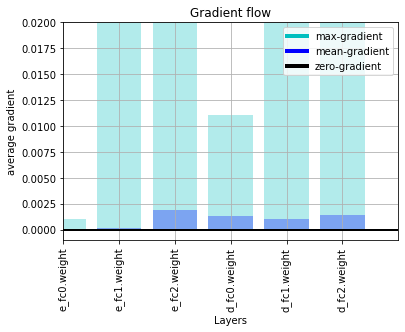

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


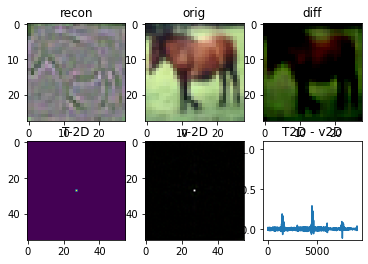

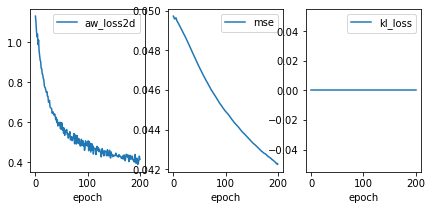

 20% (201 of 1000) |####                 | Elapsed Time: 0:01:15 ETA:   0:07:18
 20% (202 of 1000) |####                 | Elapsed Time: 0:01:15 ETA:   0:07:08
 20% (203 of 1000) |####                 | Elapsed Time: 0:01:16 ETA:   0:07:05
 20% (204 of 1000) |####                 | Elapsed Time: 0:01:16 ETA:   0:07:07
 20% (205 of 1000) |####                 | Elapsed Time: 0:01:16 ETA:   0:06:38
 20% (206 of 1000) |####                 | Elapsed Time: 0:01:17 ETA:   0:06:18
 20% (207 of 1000) |####                 | Elapsed Time: 0:01:17 ETA:   0:04:43
 20% (208 of 1000) |####                 | Elapsed Time: 0:01:17 ETA:   0:04:46
 20% (209 of 1000) |####                 | Elapsed Time: 0:01:18 ETA:   0:04:44
 21% (210 of 1000) |####                 | Elapsed Time: 0:01:18 ETA:   0:04:43
 21% (211 of 1000) |####                 | Elapsed Time: 0:01:18 ETA:   0:04:46
 21% (212 of 1000) |####                 | Elapsed Time: 0:01:19 ETA:   0:04:48
 21% (213 of 1000) |####                


 {'epoch': 300, 'train_mse': 0.040445923805236816, 'train_awi1d_loss': 0.36745965480804443, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


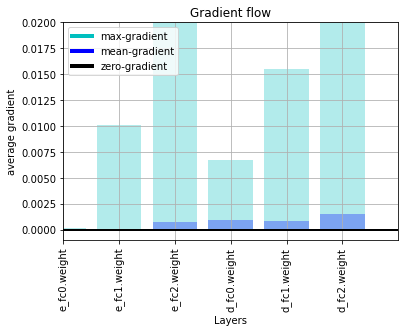

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


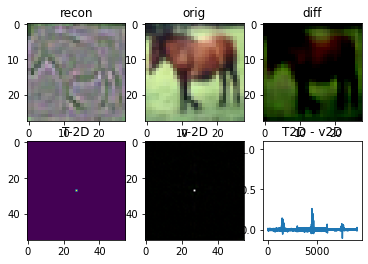

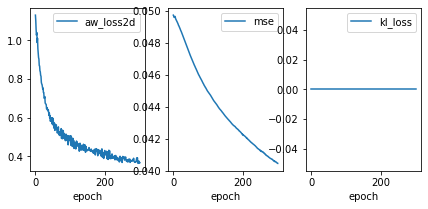

 30% (301 of 1000) |######               | Elapsed Time: 0:01:52 ETA:   0:06:02
 30% (302 of 1000) |######               | Elapsed Time: 0:01:52 ETA:   0:06:06
 30% (303 of 1000) |######               | Elapsed Time: 0:01:52 ETA:   0:06:09
 30% (304 of 1000) |######               | Elapsed Time: 0:01:53 ETA:   0:06:14
 30% (305 of 1000) |######               | Elapsed Time: 0:01:53 ETA:   0:05:48
 30% (306 of 1000) |######               | Elapsed Time: 0:01:53 ETA:   0:05:28
 30% (307 of 1000) |######               | Elapsed Time: 0:01:54 ETA:   0:04:09
 30% (308 of 1000) |######               | Elapsed Time: 0:01:54 ETA:   0:04:09
 30% (309 of 1000) |######               | Elapsed Time: 0:01:54 ETA:   0:04:06
 31% (310 of 1000) |######               | Elapsed Time: 0:01:55 ETA:   0:04:03
 31% (311 of 1000) |######               | Elapsed Time: 0:01:55 ETA:   0:04:03
 31% (312 of 1000) |######               | Elapsed Time: 0:01:56 ETA:   0:04:05
 31% (313 of 1000) |######              


 {'epoch': 400, 'train_mse': 0.03905729576945305, 'train_awi1d_loss': 0.34310537576675415, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


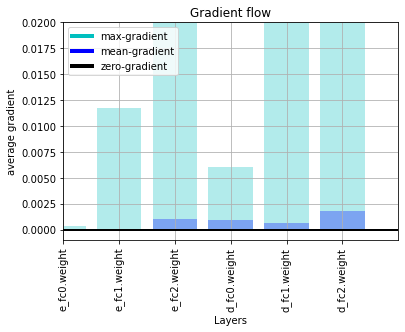

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


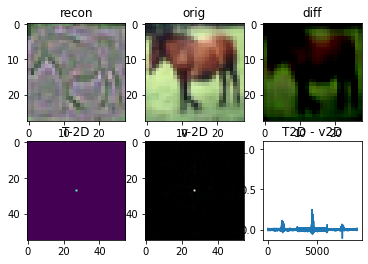

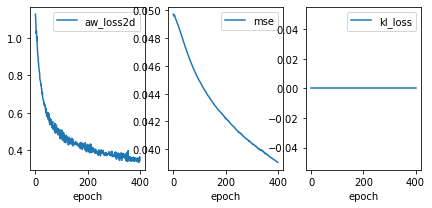

 40% (401 of 1000) |########             | Elapsed Time: 0:02:29 ETA:   0:05:33
 40% (402 of 1000) |########             | Elapsed Time: 0:02:29 ETA:   0:05:29
 40% (403 of 1000) |########             | Elapsed Time: 0:02:30 ETA:   0:05:25
 40% (404 of 1000) |########             | Elapsed Time: 0:02:30 ETA:   0:05:29
 40% (405 of 1000) |########             | Elapsed Time: 0:02:31 ETA:   0:05:09
 40% (406 of 1000) |########             | Elapsed Time: 0:02:31 ETA:   0:04:53
 40% (407 of 1000) |########             | Elapsed Time: 0:02:31 ETA:   0:03:40
 40% (408 of 1000) |########             | Elapsed Time: 0:02:32 ETA:   0:03:40
 40% (409 of 1000) |########             | Elapsed Time: 0:02:32 ETA:   0:03:44
 41% (410 of 1000) |########             | Elapsed Time: 0:02:32 ETA:   0:03:41
 41% (411 of 1000) |########             | Elapsed Time: 0:02:33 ETA:   0:03:41
 41% (412 of 1000) |########             | Elapsed Time: 0:02:33 ETA:   0:03:42
 41% (413 of 1000) |########            


 {'epoch': 500, 'train_mse': 0.03797348216176033, 'train_awi1d_loss': 0.32596835494041443, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


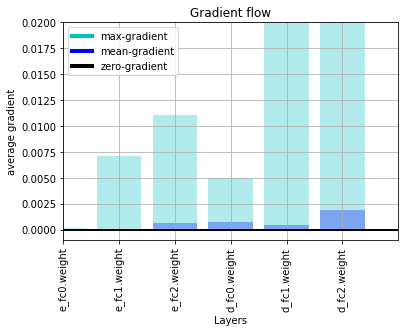

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


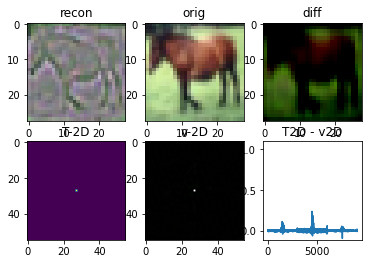

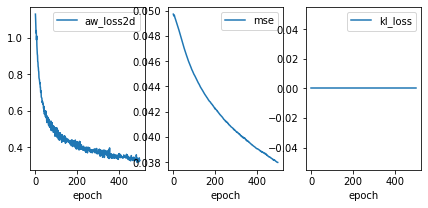

 50% (501 of 1000) |##########           | Elapsed Time: 0:03:07 ETA:   0:04:20
 50% (502 of 1000) |##########           | Elapsed Time: 0:03:07 ETA:   0:04:21
 50% (503 of 1000) |##########           | Elapsed Time: 0:03:07 ETA:   0:04:19
 50% (504 of 1000) |##########           | Elapsed Time: 0:03:08 ETA:   0:04:19
 50% (505 of 1000) |##########           | Elapsed Time: 0:03:08 ETA:   0:04:05
 50% (506 of 1000) |##########           | Elapsed Time: 0:03:08 ETA:   0:03:52
 50% (507 of 1000) |##########           | Elapsed Time: 0:03:09 ETA:   0:02:53
 50% (508 of 1000) |##########           | Elapsed Time: 0:03:09 ETA:   0:02:53
 50% (509 of 1000) |##########           | Elapsed Time: 0:03:09 ETA:   0:02:54
 51% (510 of 1000) |##########           | Elapsed Time: 0:03:10 ETA:   0:02:52
 51% (511 of 1000) |##########           | Elapsed Time: 0:03:10 ETA:   0:02:49
 51% (512 of 1000) |##########           | Elapsed Time: 0:03:10 ETA:   0:02:49
 51% (513 of 1000) |##########          


 {'epoch': 600, 'train_mse': 0.03697255626320839, 'train_awi1d_loss': 0.28962409496307373, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


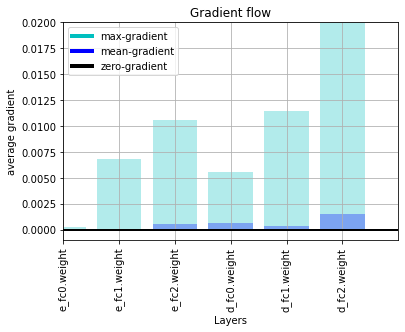

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


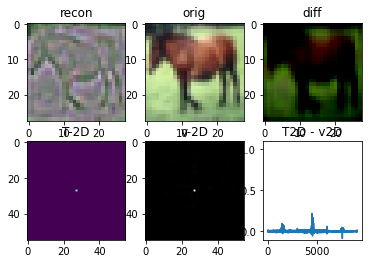

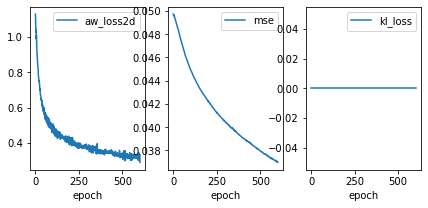

 60% (601 of 1000) |############         | Elapsed Time: 0:03:44 ETA:   0:03:40
 60% (602 of 1000) |############         | Elapsed Time: 0:03:44 ETA:   0:03:39
 60% (603 of 1000) |############         | Elapsed Time: 0:03:44 ETA:   0:03:37
 60% (604 of 1000) |############         | Elapsed Time: 0:03:45 ETA:   0:03:34
 60% (605 of 1000) |############         | Elapsed Time: 0:03:45 ETA:   0:03:21
 60% (606 of 1000) |############         | Elapsed Time: 0:03:45 ETA:   0:03:10
 60% (607 of 1000) |############         | Elapsed Time: 0:03:46 ETA:   0:02:21
 60% (608 of 1000) |############         | Elapsed Time: 0:03:46 ETA:   0:02:20
 60% (609 of 1000) |############         | Elapsed Time: 0:03:47 ETA:   0:02:20
 61% (610 of 1000) |############         | Elapsed Time: 0:03:47 ETA:   0:02:19
 61% (611 of 1000) |############         | Elapsed Time: 0:03:47 ETA:   0:02:16
 61% (612 of 1000) |############         | Elapsed Time: 0:03:48 ETA:   0:02:19
 61% (613 of 1000) |############        


 {'epoch': 700, 'train_mse': 0.03616102784872055, 'train_awi1d_loss': 0.3025912642478943, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


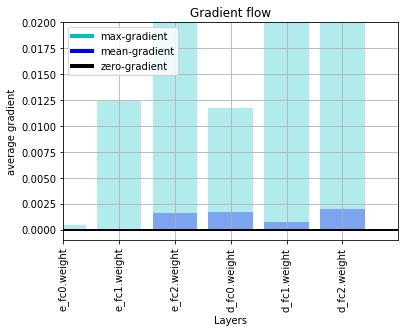

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


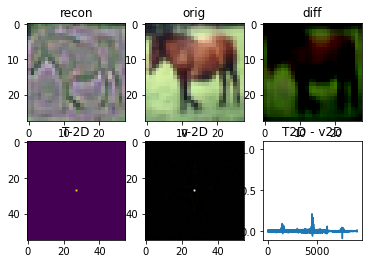

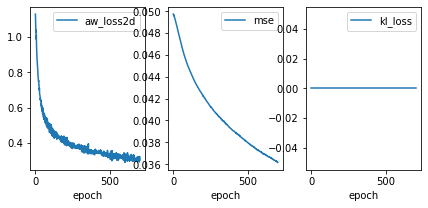

 70% (701 of 1000) |##############       | Elapsed Time: 0:04:21 ETA:   0:02:44
 70% (702 of 1000) |##############       | Elapsed Time: 0:04:22 ETA:   0:02:42
 70% (703 of 1000) |##############       | Elapsed Time: 0:04:22 ETA:   0:02:41
 70% (704 of 1000) |##############       | Elapsed Time: 0:04:22 ETA:   0:02:39
 70% (705 of 1000) |##############       | Elapsed Time: 0:04:23 ETA:   0:02:29
 70% (706 of 1000) |##############       | Elapsed Time: 0:04:23 ETA:   0:02:21
 70% (707 of 1000) |##############       | Elapsed Time: 0:04:24 ETA:   0:01:47
 70% (708 of 1000) |##############       | Elapsed Time: 0:04:24 ETA:   0:01:46
 70% (709 of 1000) |##############       | Elapsed Time: 0:04:24 ETA:   0:01:46
 71% (710 of 1000) |##############       | Elapsed Time: 0:04:25 ETA:   0:01:44
 71% (711 of 1000) |##############       | Elapsed Time: 0:04:25 ETA:   0:01:44
 71% (712 of 1000) |##############       | Elapsed Time: 0:04:25 ETA:   0:01:45
 71% (713 of 1000) |##############      


 {'epoch': 800, 'train_mse': 0.03545427322387695, 'train_awi1d_loss': 0.28981512784957886, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


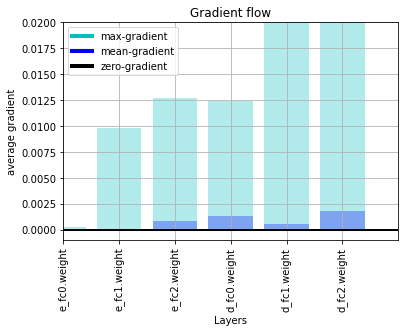

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


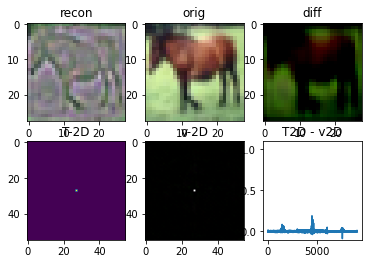

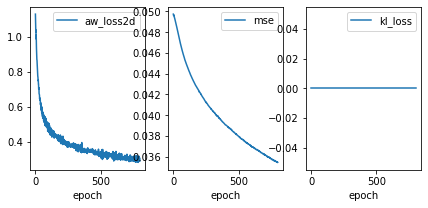

 80% (801 of 1000) |################     | Elapsed Time: 0:04:59 ETA:   0:01:47
 80% (802 of 1000) |################     | Elapsed Time: 0:04:59 ETA:   0:01:45
 80% (803 of 1000) |################     | Elapsed Time: 0:05:00 ETA:   0:01:45
 80% (804 of 1000) |################     | Elapsed Time: 0:05:00 ETA:   0:01:43
 80% (805 of 1000) |################     | Elapsed Time: 0:05:00 ETA:   0:01:36
 80% (806 of 1000) |################     | Elapsed Time: 0:05:01 ETA:   0:01:31
 80% (807 of 1000) |################     | Elapsed Time: 0:05:01 ETA:   0:01:08
 80% (808 of 1000) |################     | Elapsed Time: 0:05:02 ETA:   0:01:09
 80% (809 of 1000) |################     | Elapsed Time: 0:05:02 ETA:   0:01:08
 81% (810 of 1000) |#################    | Elapsed Time: 0:05:02 ETA:   0:01:08
 81% (811 of 1000) |#################    | Elapsed Time: 0:05:03 ETA:   0:01:07
 81% (812 of 1000) |#################    | Elapsed Time: 0:05:03 ETA:   0:01:08
 81% (813 of 1000) |#################   


 {'epoch': 900, 'train_mse': 0.0347239151597023, 'train_awi1d_loss': 0.2869652509689331, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


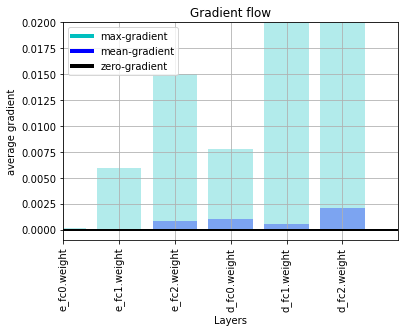

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


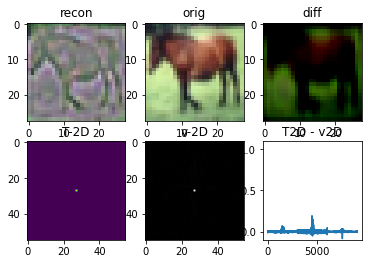

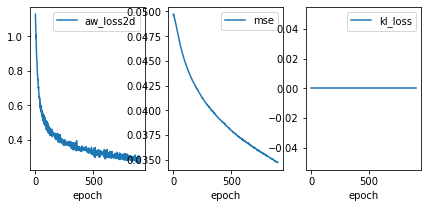

 90% (901 of 1000) |##################   | Elapsed Time: 0:05:37 ETA:   0:00:53
 90% (902 of 1000) |##################   | Elapsed Time: 0:05:37 ETA:   0:00:52
 90% (903 of 1000) |##################   | Elapsed Time: 0:05:37 ETA:   0:00:51
 90% (904 of 1000) |##################   | Elapsed Time: 0:05:38 ETA:   0:00:51
 90% (905 of 1000) |###################  | Elapsed Time: 0:05:38 ETA:   0:00:48
 90% (906 of 1000) |###################  | Elapsed Time: 0:05:38 ETA:   0:00:45
 90% (907 of 1000) |###################  | Elapsed Time: 0:05:39 ETA:   0:00:34
 90% (908 of 1000) |###################  | Elapsed Time: 0:05:39 ETA:   0:00:33
 90% (909 of 1000) |###################  | Elapsed Time: 0:05:39 ETA:   0:00:33
 91% (910 of 1000) |###################  | Elapsed Time: 0:05:40 ETA:   0:00:33
 91% (911 of 1000) |###################  | Elapsed Time: 0:05:40 ETA:   0:00:32
 91% (912 of 1000) |###################  | Elapsed Time: 0:05:41 ETA:   0:00:32
 91% (913 of 1000) |################### 


 {'epoch': 999, 'train_mse': 0.03410729765892029, 'train_awi1d_loss': 0.2928481996059418, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


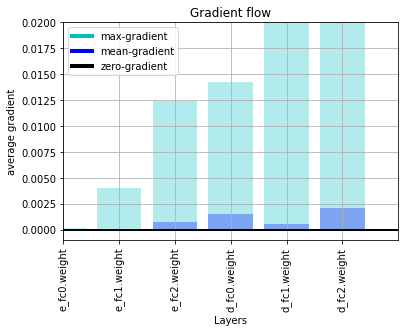

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


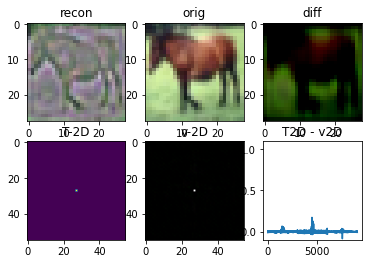

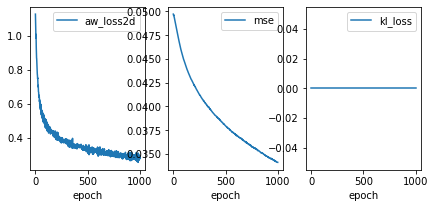

100% (1000 of 1000) |####################| Elapsed Time: 0:06:13 Time:  0:06:13


In [18]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=100)

## Visualise Loss Landscape of Autoencoder

Train Subset len:  1
Angle between x_dir and y_dir: 90.05 °


100% (625 of 625) |######################| Elapsed Time: 0:04:52 Time:  0:04:52


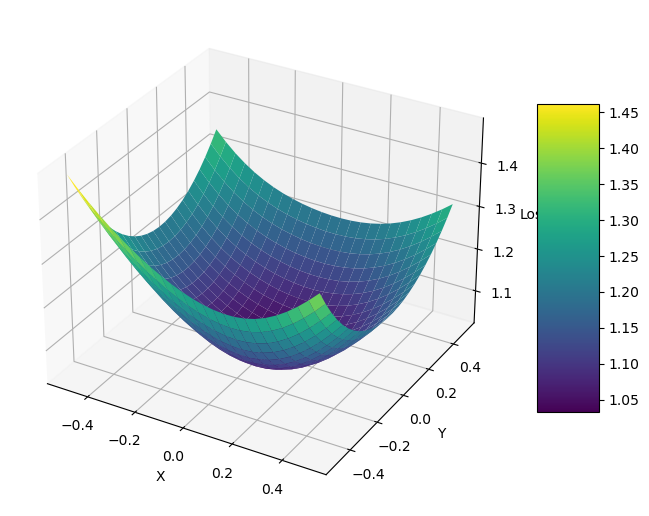

In [9]:
train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=1)))
train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
print("Train Subset len: ", len(train_subset))
xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi2D, device=device)


## Variational Autoencoder (FC)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.06793513894081116, 'train_awi1d_loss': 20.94304656982422, 'train_kl_loss': 286.55810546875}
 argidx T, v:  1512 1512


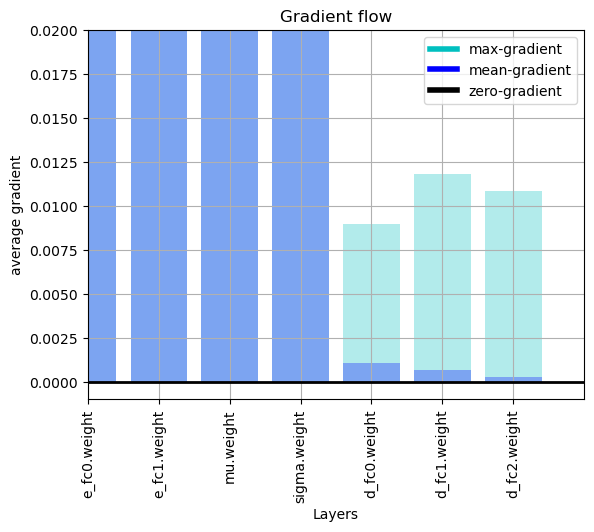

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


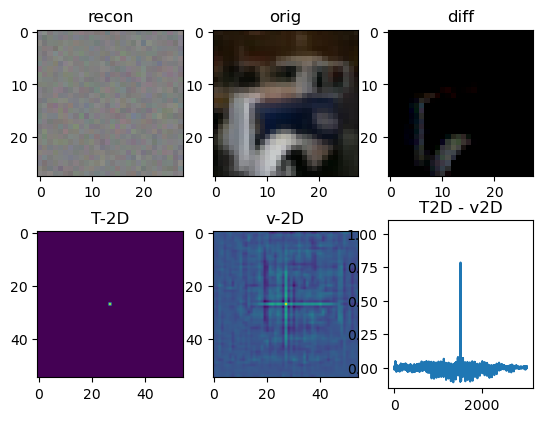

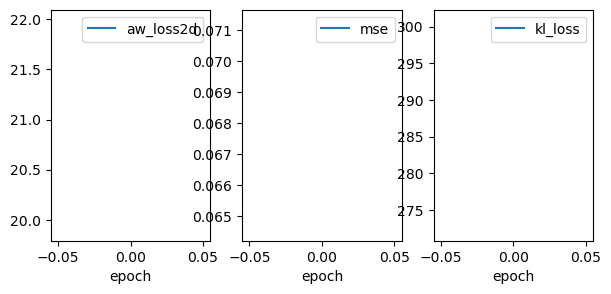

 20% (20 of 100) |####                   | Elapsed Time: 0:05:29 ETA:   0:20:53


 {'epoch': 20, 'train_mse': 0.06924005597829819, 'train_awi1d_loss': 19.77944564819336, 'train_kl_loss': 216.04673767089844}
 argidx T, v:  1512 1512


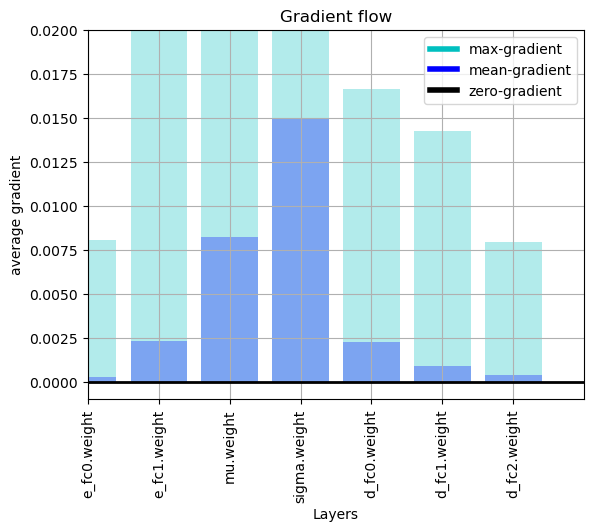

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


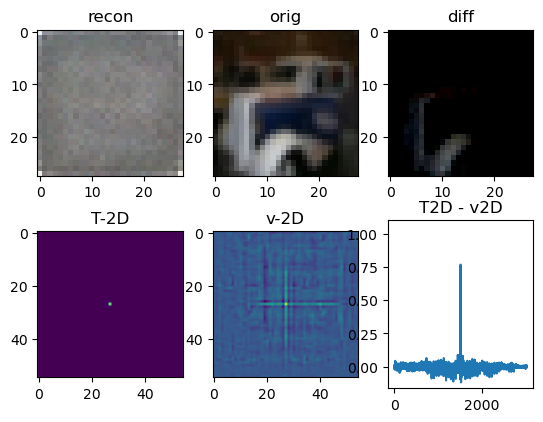

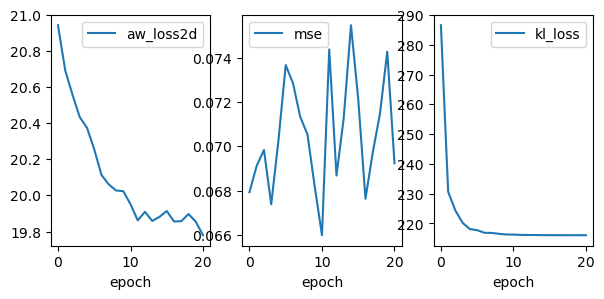

 40% (40 of 100) |#########              | Elapsed Time: 0:11:05 ETA:   0:17:28


 {'epoch': 40, 'train_mse': 0.06957788020372391, 'train_awi1d_loss': 19.75606918334961, 'train_kl_loss': 216.10250854492188}
 argidx T, v:  1512 1512


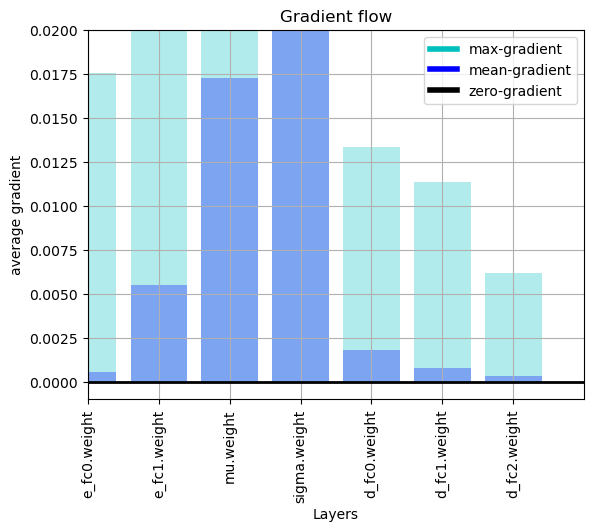

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


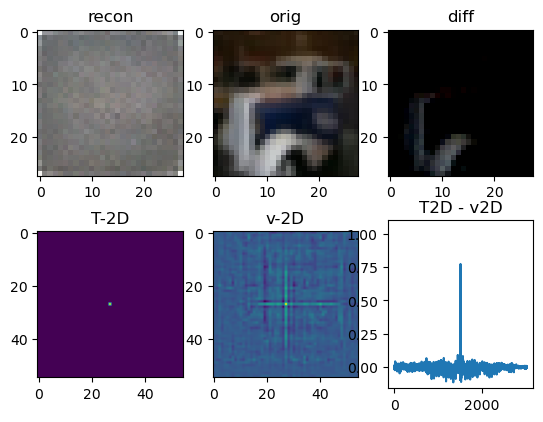

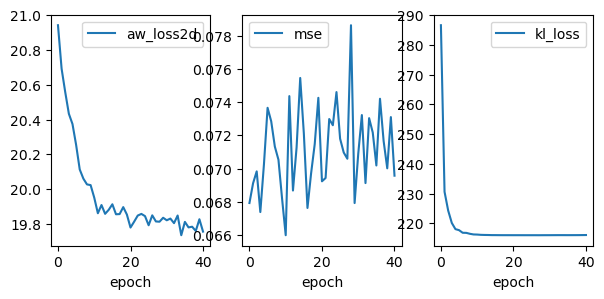

 60% (60 of 100) |#############          | Elapsed Time: 0:16:20 ETA:   0:10:22


 {'epoch': 60, 'train_mse': 0.07567473500967026, 'train_awi1d_loss': 19.763334274291992, 'train_kl_loss': 216.03565979003906}
 argidx T, v:  1512 1512


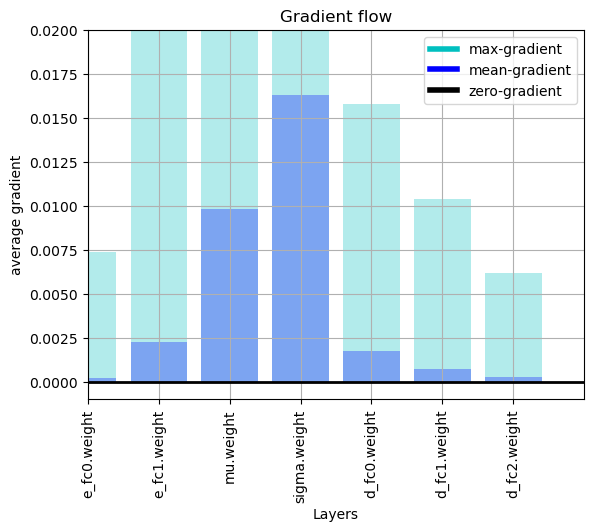

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


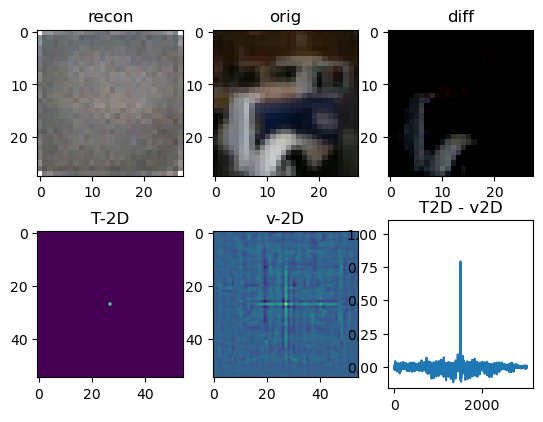

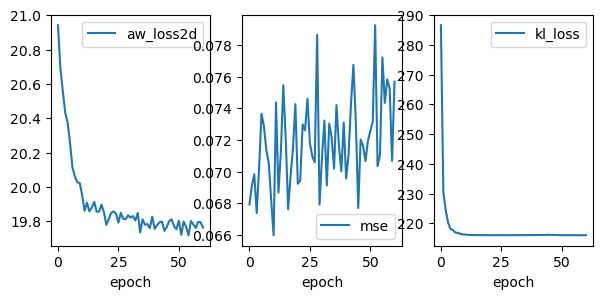

 80% (80 of 100) |##################     | Elapsed Time: 0:21:31 ETA:   0:05:12


 {'epoch': 80, 'train_mse': 0.07943153381347656, 'train_awi1d_loss': 19.758865356445312, 'train_kl_loss': 216.0413360595703}
 argidx T, v:  1512 1512


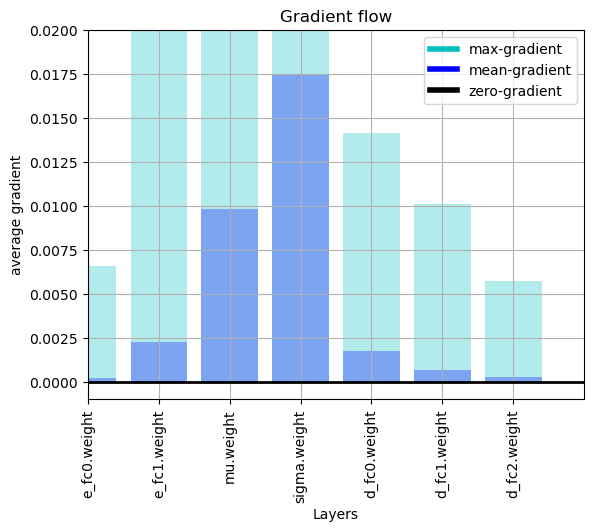

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


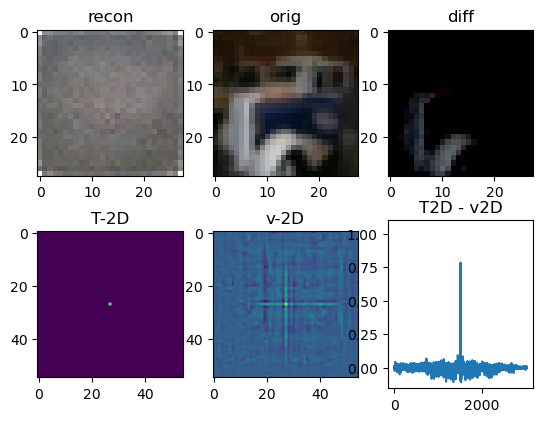

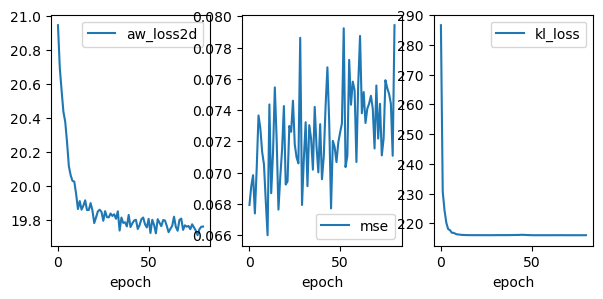

 99% (99 of 100) |###################### | Elapsed Time: 0:26:27 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.07769592851400375, 'train_awi1d_loss': 19.680139541625977, 'train_kl_loss': 216.03082275390625}
 argidx T, v:  1512 1512


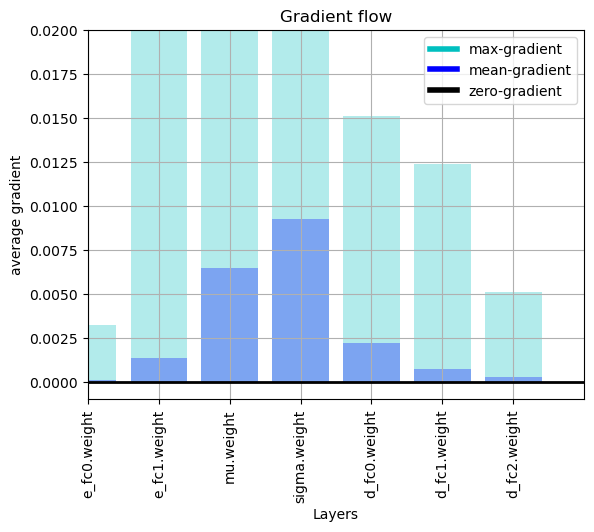

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


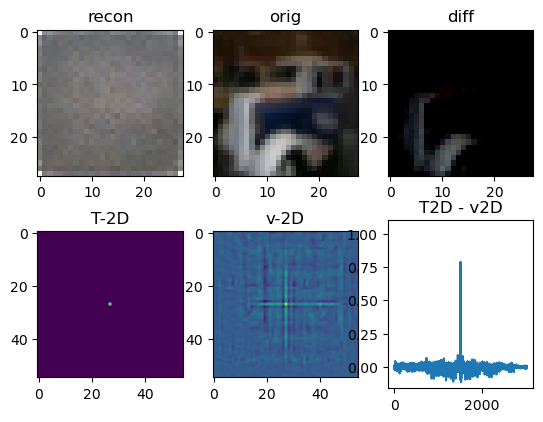

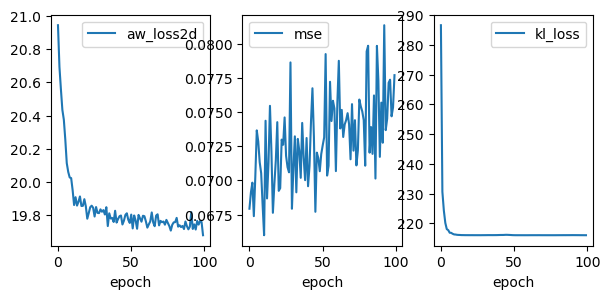

100% (100 of 100) |######################| Elapsed Time: 0:26:28 Time:  0:26:28


In [10]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
 
# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-9n7gsq15/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'train_mse': 0.04765557497739792, 'train_awi1d_loss': 1.1341084241867065, 'train_kl_loss': 0.0}
 argidx T, v:  1512 4537


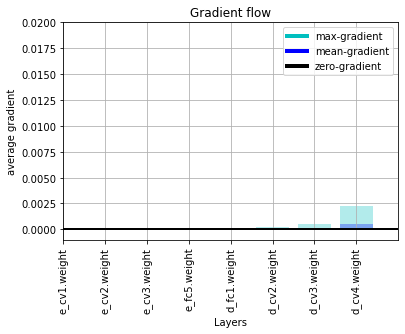

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


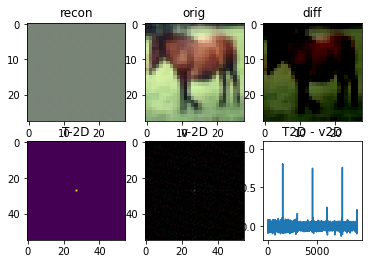

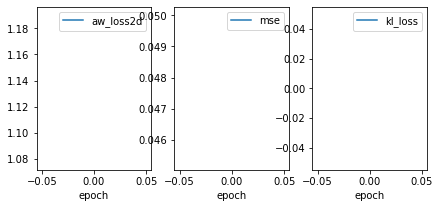

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:05
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:18
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:03
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:55
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:49
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:46
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:31
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:31
  9% (9 of 100) |##                      | Elapsed Time: 0:00:03 ETA:   0:00:30
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:30
 11% (11 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:29
 12% (12 of 100) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:30
 13% (13 of 100) |##                    


 {'epoch': 20, 'train_mse': 0.04761117696762085, 'train_awi1d_loss': 0.9227211475372314, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


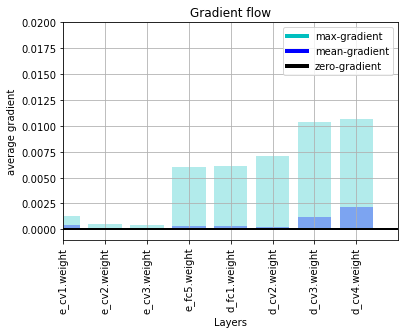

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


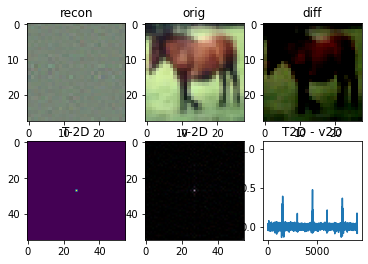

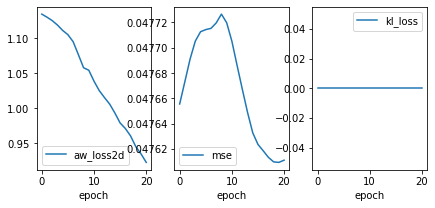

 21% (21 of 100) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:43
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:43
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:42
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:09 ETA:   0:00:42
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:37
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:34
 27% (27 of 100) |######                 | Elapsed Time: 0:00:10 ETA:   0:00:31
 28% (28 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:21
 29% (29 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:21
 30% (30 of 100) |######                 | Elapsed Time: 0:00:11 ETA:   0:00:21
 31% (31 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:21
 32% (32 of 100) |#######                | Elapsed Time: 0:00:12 ETA:   0:00:21
 33% (33 of 100) |#######               


 {'epoch': 40, 'train_mse': 0.04704449698328972, 'train_awi1d_loss': 0.7349563241004944, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


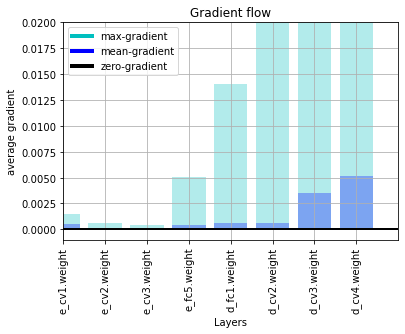

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


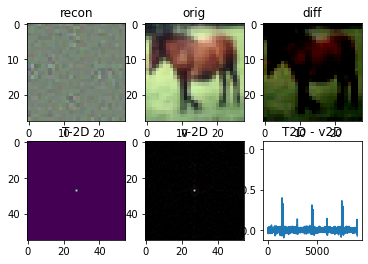

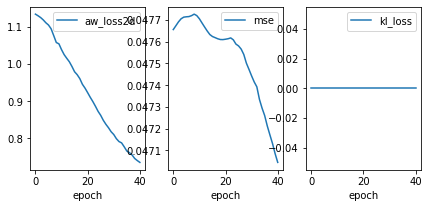

 41% (41 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:33
 42% (42 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:32
 43% (43 of 100) |#########              | Elapsed Time: 0:00:16 ETA:   0:00:32
 44% (44 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:30
 45% (45 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:27
 46% (46 of 100) |##########             | Elapsed Time: 0:00:17 ETA:   0:00:25
 47% (47 of 100) |##########             | Elapsed Time: 0:00:18 ETA:   0:00:24
 48% (48 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 49% (49 of 100) |###########            | Elapsed Time: 0:00:18 ETA:   0:00:17
 50% (50 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 51% (51 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 52% (52 of 100) |###########            | Elapsed Time: 0:00:19 ETA:   0:00:16
 53% (53 of 100) |############          


 {'epoch': 60, 'train_mse': 0.04624343290925026, 'train_awi1d_loss': 0.6319090723991394, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


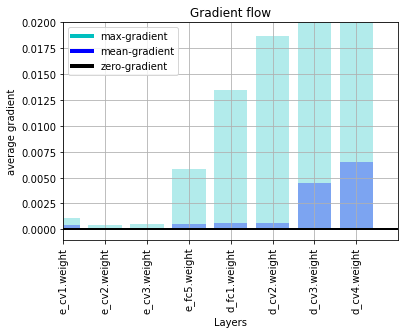

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


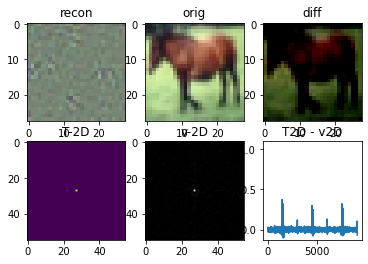

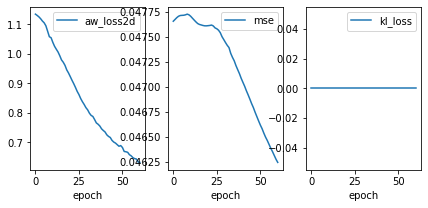

 61% (61 of 100) |##############         | Elapsed Time: 0:00:23 ETA:   0:00:21
 62% (62 of 100) |##############         | Elapsed Time: 0:00:24 ETA:   0:00:21
 63% (63 of 100) |##############         | Elapsed Time: 0:00:24 ETA:   0:00:20
 64% (64 of 100) |##############         | Elapsed Time: 0:00:24 ETA:   0:00:20
 65% (65 of 100) |##############         | Elapsed Time: 0:00:25 ETA:   0:00:18
 66% (66 of 100) |###############        | Elapsed Time: 0:00:25 ETA:   0:00:17
 67% (67 of 100) |###############        | Elapsed Time: 0:00:25 ETA:   0:00:11
 68% (68 of 100) |###############        | Elapsed Time: 0:00:26 ETA:   0:00:11
 69% (69 of 100) |###############        | Elapsed Time: 0:00:26 ETA:   0:00:10
 70% (70 of 100) |################       | Elapsed Time: 0:00:27 ETA:   0:00:10
 71% (71 of 100) |################       | Elapsed Time: 0:00:27 ETA:   0:00:10
 72% (72 of 100) |################       | Elapsed Time: 0:00:27 ETA:   0:00:09
 73% (73 of 100) |################      


 {'epoch': 80, 'train_mse': 0.04553784802556038, 'train_awi1d_loss': 0.5722709894180298, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


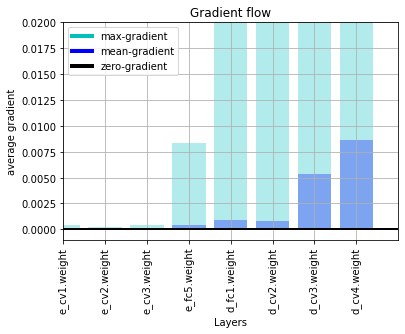

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


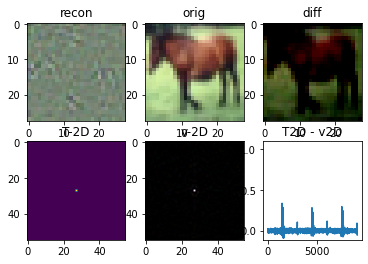

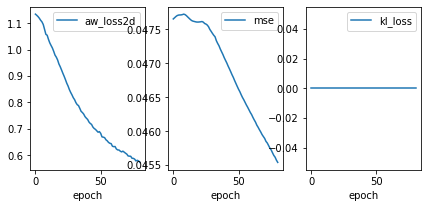

 81% (81 of 100) |##################     | Elapsed Time: 0:00:31 ETA:   0:00:10
 82% (82 of 100) |##################     | Elapsed Time: 0:00:31 ETA:   0:00:10
 83% (83 of 100) |###################    | Elapsed Time: 0:00:32 ETA:   0:00:09
 84% (84 of 100) |###################    | Elapsed Time: 0:00:32 ETA:   0:00:09
 85% (85 of 100) |###################    | Elapsed Time: 0:00:32 ETA:   0:00:07
 86% (86 of 100) |###################    | Elapsed Time: 0:00:33 ETA:   0:00:06
 87% (87 of 100) |####################   | Elapsed Time: 0:00:33 ETA:   0:00:05
 88% (88 of 100) |####################   | Elapsed Time: 0:00:33 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:34 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:34 ETA:   0:00:03
 91% (91 of 100) |####################   | Elapsed Time: 0:00:34 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:35 ETA:   0:00:02
 93% (93 of 100) |##################### 


 {'epoch': 99, 'train_mse': 0.04483215510845184, 'train_awi1d_loss': 0.5350640416145325, 'train_kl_loss': 0.0}
 argidx T, v:  1512 7562


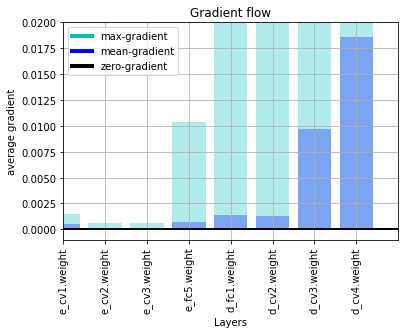

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HELLO torch.Size([55, 55])


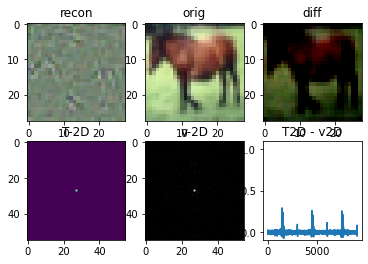

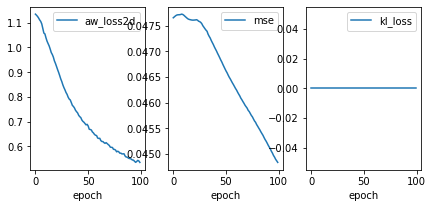

100% (100 of 100) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


In [6]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Variational Autoencoder (CNN)

torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.07105135917663574, 'train_awi1d_loss': 20.72090721130371, 'train_kl_loss': 217.8638458251953}
 argidx T, v:  1512 1512


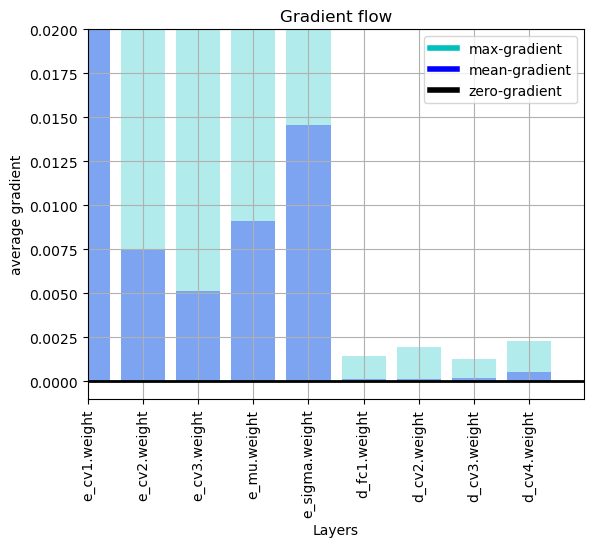

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


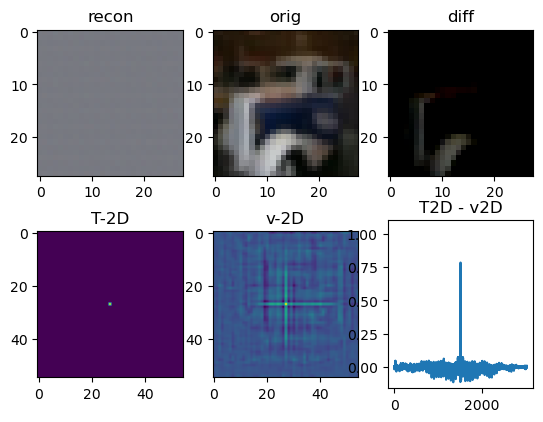

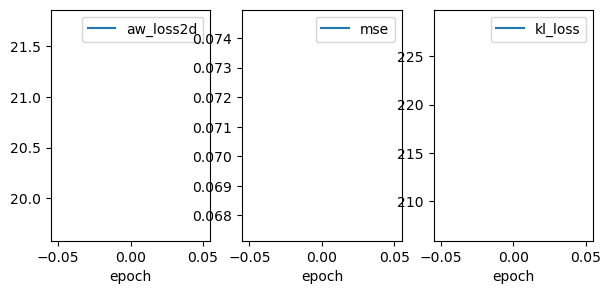

 20% (20 of 100) |####                   | Elapsed Time: 0:05:13 ETA:   0:20:39


 {'epoch': 20, 'train_mse': 0.075208380818367, 'train_awi1d_loss': 19.836681365966797, 'train_kl_loss': 216.0145721435547}
 argidx T, v:  1512 1512


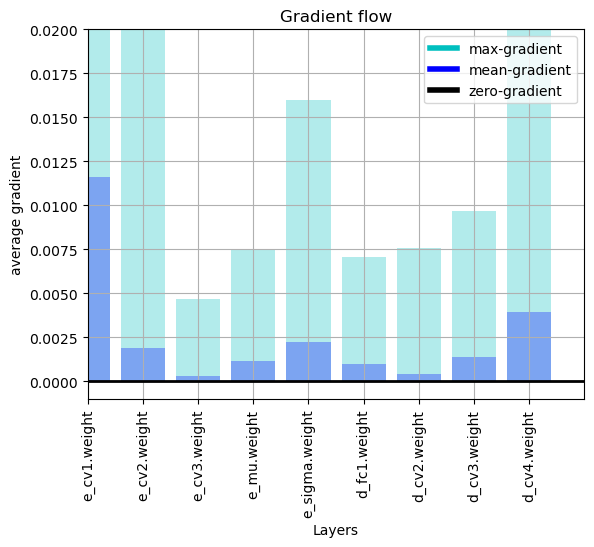

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


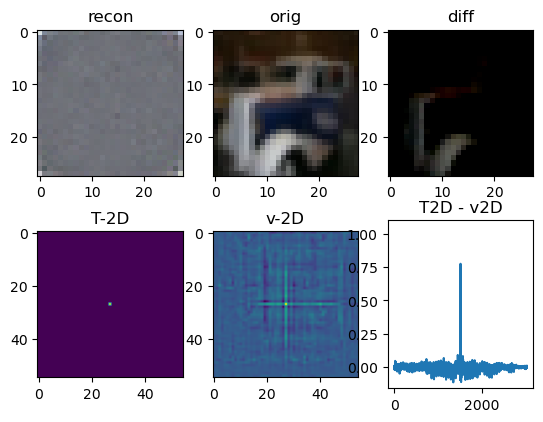

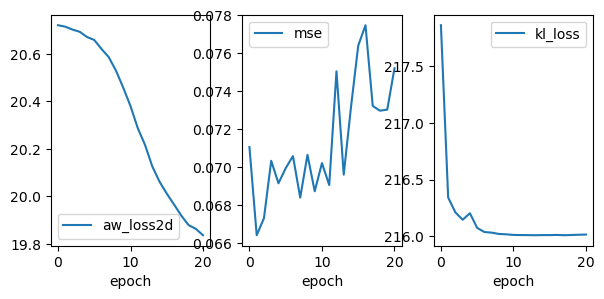

 40% (40 of 100) |#########              | Elapsed Time: 0:10:24 ETA:   0:15:29


 {'epoch': 40, 'train_mse': 0.07696622610092163, 'train_awi1d_loss': 19.710792541503906, 'train_kl_loss': 216.00160217285156}
 argidx T, v:  1512 1512


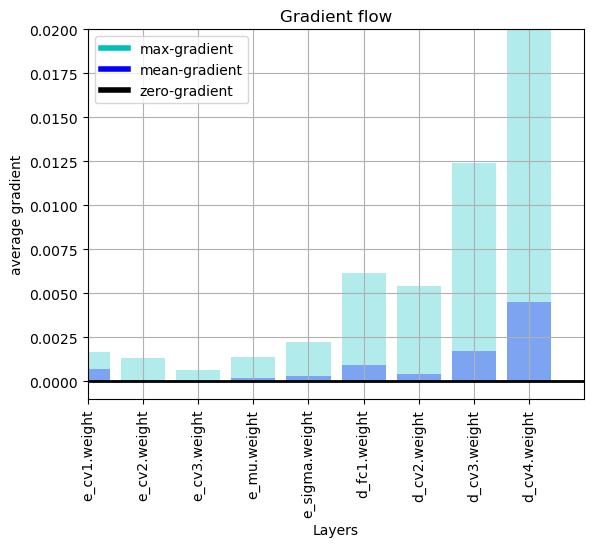

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


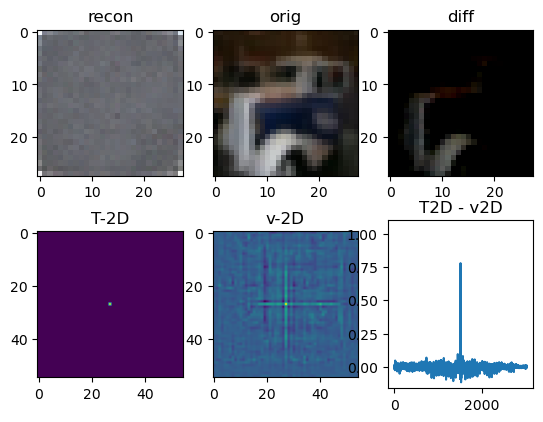

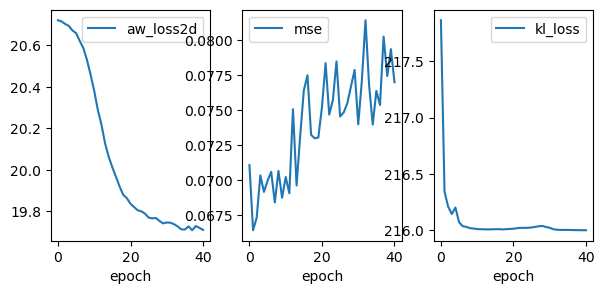

 60% (60 of 100) |#############          | Elapsed Time: 0:15:35 ETA:   0:10:24


 {'epoch': 60, 'train_mse': 0.07918272912502289, 'train_awi1d_loss': 19.687294006347656, 'train_kl_loss': 216.00076293945312}
 argidx T, v:  1512 1512


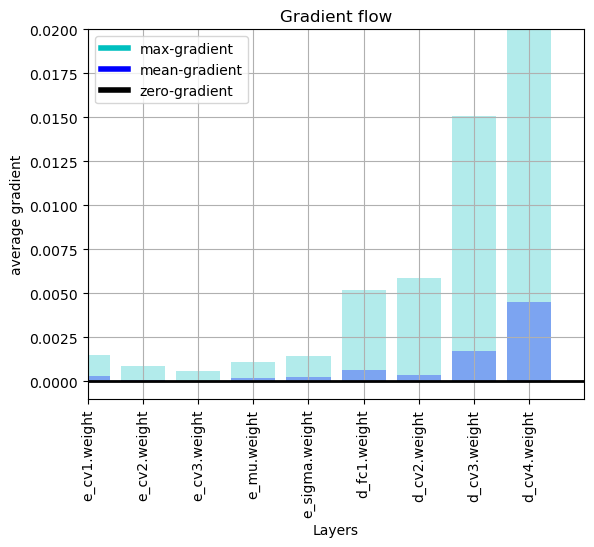

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


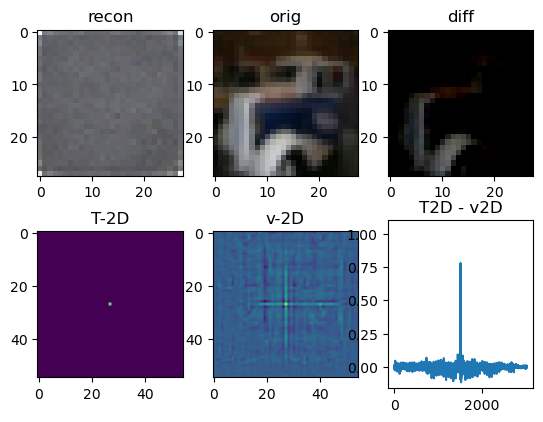

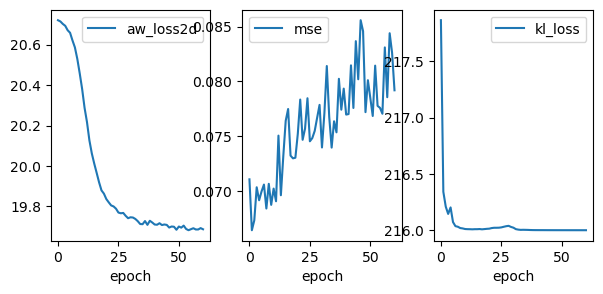

 80% (80 of 100) |##################     | Elapsed Time: 0:20:47 ETA:   0:05:09


 {'epoch': 80, 'train_mse': 0.08046561479568481, 'train_awi1d_loss': 19.673202514648438, 'train_kl_loss': 216.00070190429688}
 argidx T, v:  1512 1512


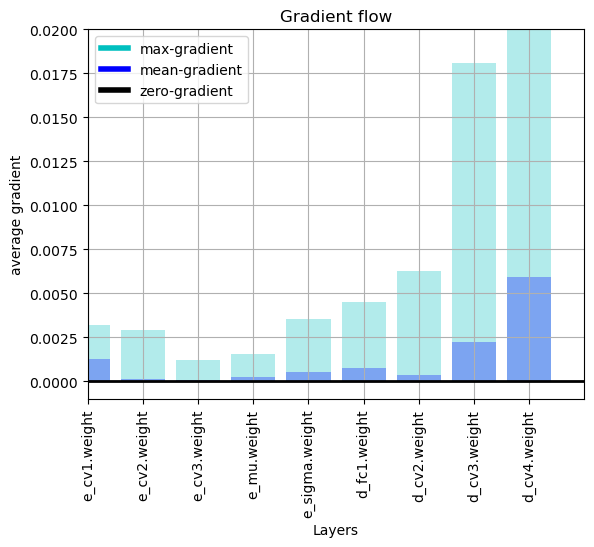

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


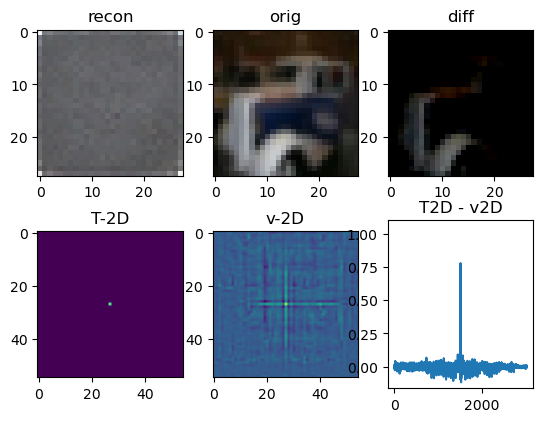

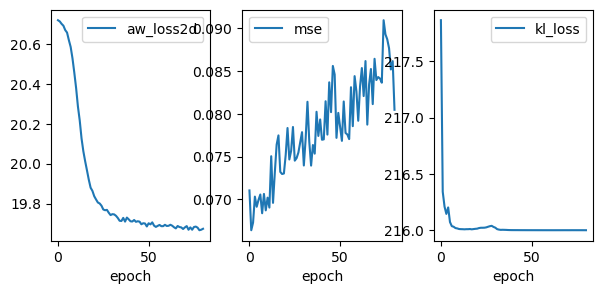

 99% (99 of 100) |###################### | Elapsed Time: 0:25:43 ETA:   0:00:15


 {'epoch': 99, 'train_mse': 0.0870574414730072, 'train_awi1d_loss': 19.670400619506836, 'train_kl_loss': 216.00282287597656}
 argidx T, v:  1512 1512


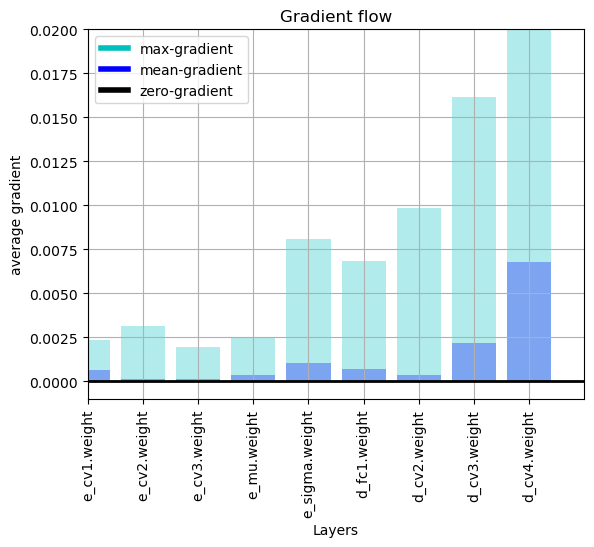

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


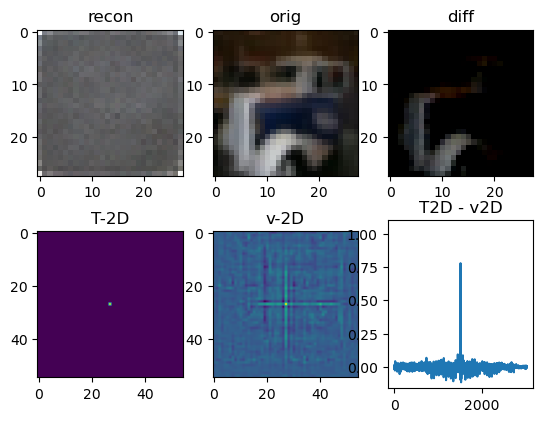

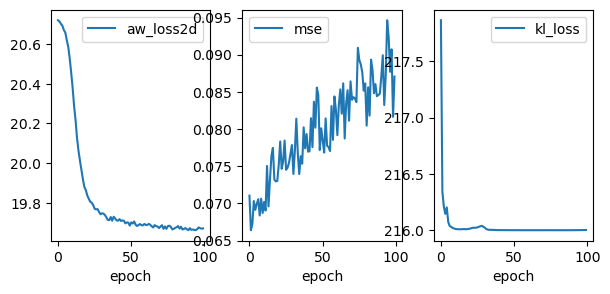

100% (100 of 100) |######################| Elapsed Time: 0:25:44 Time:  0:25:44


In [12]:
model = CVAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)